In [45]:
import os
import sys
from pathlib import Path
import json
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from rdkit import Chem
import numpy as np
import rdkit
from matplotlib.colors import LinearSegmentedColormap

sys.path.append('../')
from config import ROOT_DIR

%matplotlib inline
sns.set_theme(palette='plasma', style='whitegrid', font_scale=1.3)
warnings.filterwarnings('ignore')

model = 'tsne-based'
version = 'snake'

In [13]:
def model_path(model, version):
    return ROOT_DIR / 'Output' / model / version

In [24]:
def make_model_predictions(model, version):
    os.system(f"python3 apply_model --model={model}, --version={version}")

In [32]:
def from_json(model, version):
    with open(model_path(model, version) / 'metrics.json') as f:
        data = json.load(f)
    from_json.metrics = r'R2 RMSE MAE'.split()
    metrics = from_json.metrics
    modes = 'train valid test'.split()
    metrics_dict = {}
    
    for mode in modes:
        metrics_dict[mode] = [data[f"logK_{mode}_{m}"] for m in metrics]
    
    return metrics_dict

In [34]:
def draw_df(df, ax, use_title=True, title=None):
    """
    Used for draw metrics df
    """
    colors = [(1, 1, 1, 0), (1, 1, 1, 1)]  # White color with varying alpha (transparent to opaque)
    n_bins = 100  # Discretize the colormap into 100 bins
    cmap_name = 'transparent_white'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
    sns.heatmap(df, cmap=cm, annot=True, fmt='.4f', cbar=False, ax=ax, linewidths=2, linecolor='black')
    ax.set_yticklabels([r"$R^{2}$", "RMSE", 'MAE'], fontsize=15)
    ax.set_xticklabels([f"${mode}$" for mode in ['train', 'val', 'test']], fontsize=15)
    ax.xaxis.tick_top()
    ax.set_title((title if title else model) if use_title else None, fontsize=20)

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(2)
    return ax

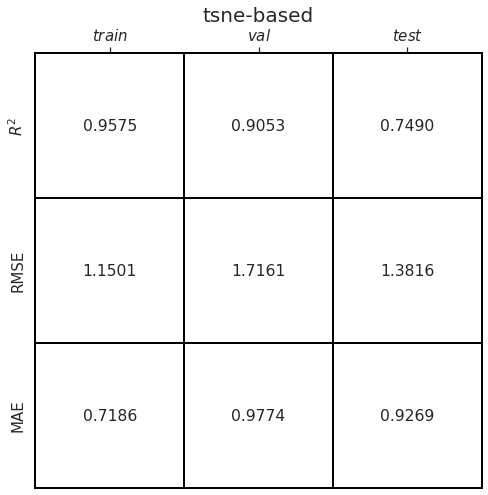

In [43]:
def json2df(model, version, draw=False, use_title=True, title=None, ax=None):
    if not os.path.exists(model_path(model, version) / 'metrics.json'):
        make_model_predictions(model, version)
        
    metrics_dict = from_json(model, version)
    df = pd.DataFrame(metrics_dict, index=from_json.metrics)
    
    if draw:   
        ax = draw_df(df=df, ax=ax, use_title=use_title, title=title)
    
    return (df, ax) if draw else df

json2df(model, version, draw=True);

In [15]:
def json2tex(model, version, save=False):
    df = json2df(model, version)
    tex = df.to_latex(float_format="{:0.2f}".format)
    if save:
        with open(f"{model_path(model, version)}/metrics.tex", 'w') as f:
            f.write(r"\begin{document}" + f"\n{tex}\n" + r"\end{document}")
            return
    
    return tex

In [16]:
def draw_model(df, model, metals, axs=None, title=None):
    if len(metals) != 1:
        nrows = len(metals) // 2
        ncols = len(metals) // nrows
    else:
        nrows = ncols = 1
    
    if axs is None:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8 * ncols, 8 * nrows))
    print(type(axs))
    for metal, ax in zip(metals, axs.flat if len(metals) != 1 else [axs]):
        sns.scatterplot(data=df, x=f"{metal}_true", y=metal, ax=ax)
        ax.set_xlabel('$logK_{true}$')
        ax.set_ylabel('$logK_{pred}$')
        ax.plot(df[f"{metal}_true"], df[f"{metal}_true"], color='red', alpha=0.8, label='$logK_{true} = logK_{pred}$')
        ax.legend(fontsize=14)
        ax.set_title(metal, fontsize=18)
    fig.suptitle(f"{title if title else model}", fontsize=20)

    
    return fig, axs

In [17]:
def get_df(model, version, sdf_path='Data/OneM_cond_adds', csv_name='predictions', draw=False, return_mols=False, title=None):
    sdf_path = ROOT_DIR / sdf_path
    df = pd.read_csv(model_path(model, version)/f"{csv_name}.csv", index_col=0)
    metals = df.columns.to_list()
    
    y_true = {}
    y_pred = {}
    mols = {}
    mol_names = {}
    Mols = {}

    for metal in metals:
    
        y_pred[metal] = df[metal].dropna().values
    
        logK = []
        names = []
        objs = []
        mols[metal] = [mol for mol in Chem.SDMolSupplier(str(sdf_path/f"{metal}.sdf")) if mol is not None]
    
        for mol in mols[metal]:
            props = [prop for prop in mol.GetPropNames() if prop.startswith("logK_")]
            names.extend([mol.GetProp('Name')] * len(props))
            objs.extend([mol] * len(props))
            for prop in props:
                logK.append(mol.GetProp(prop))
                logK = [float(x) for x in logK]

        y_true[metal] = logK
        mol_names[metal] = names
        Mols[metal] = objs
    
    max_len = max([len(y) for y in y_true.values()])
    
    for metal in metals:
        len_ = len(y_true[metal])
        if len_ < max_len:
            y_true[metal].extend([np.nan] * (max_len - len_))
    
        df[f"{metal}_true"] = y_true[metal]
        
    if draw:
        fig, axs = draw_model(df, model, metals, title=title)
        plt.show()
    
    return (df, (Mols, mol_names)) if return_mols else df

In [ ]:
def draw_report(model, version, title=None, fig=None, axs=None):
    df = get_df(model, version)
    
    if not fig:
         fig, axs = plt.subplots(ncols=2, nrows=1, figsize=figsize=(16, 8))
    
    fig.suptitle(title if title else model)
    ax1, ax2 = axs.flat
    sns.scatterplot(data=df, x='Sr', y='Sr_true')

[16:31:50] ERROR: EOF hit while reading bonds
[16:31:50] ERROR: moving to the beginning of the next molecule
[16:31:50] ERROR: EOF hit while reading bonds
[16:31:50] ERROR: moving to the beginning of the next molecule


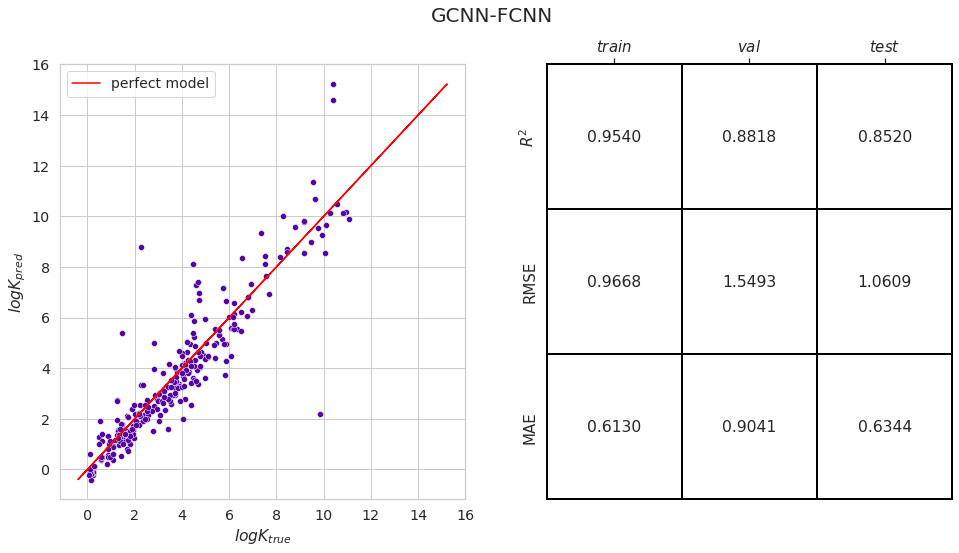

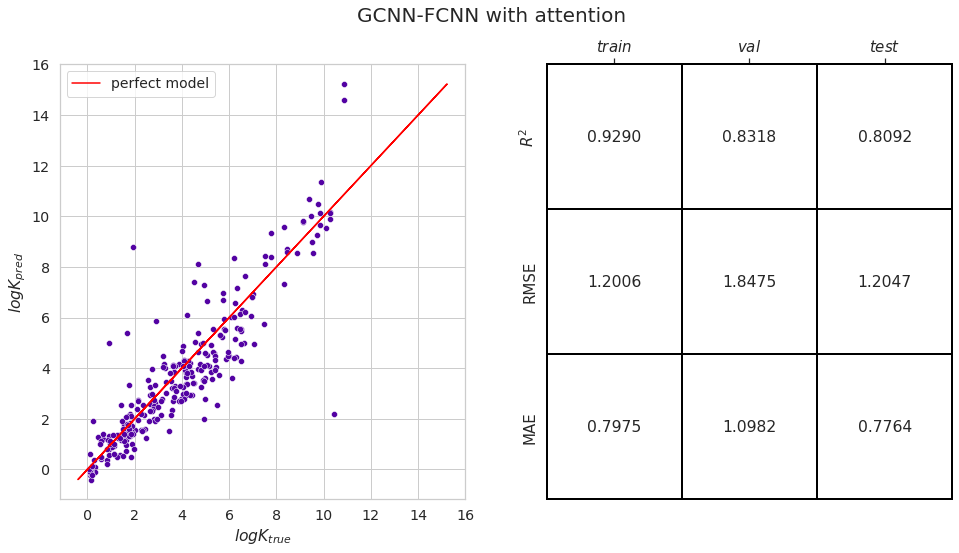

In [46]:
for model, version, title in zip(models, versions, titles):
    fig, axs = plt.subplots(figsize=(16, 8), ncols=2, nrows=1)
    fig.suptitle(title, fontsize=20)
    model_df = get_df(model, version, draw=False, return_mols=False)

    ax = axs.flat[0]
    sns.scatterplot(data=model_df, x='Sr', y='Sr_true', ax=ax)
    ax.plot(model_df['Sr_true'], model_df['Sr_true'], color='red', label='perfect model')
    #ax.set_title(title)
    ax.legend(fontsize=14)
    ax.set_xlabel('$logK_{true}$')
    ax.set_ylabel('$logK_{pred}$')

    ax = axs.flat[1]
    json2df(model, version, ax=ax, draw=True, use_title=False)

[16:32:03] ERROR: EOF hit while reading bonds
[16:32:03] ERROR: moving to the beginning of the next molecule


<class 'numpy.ndarray'>


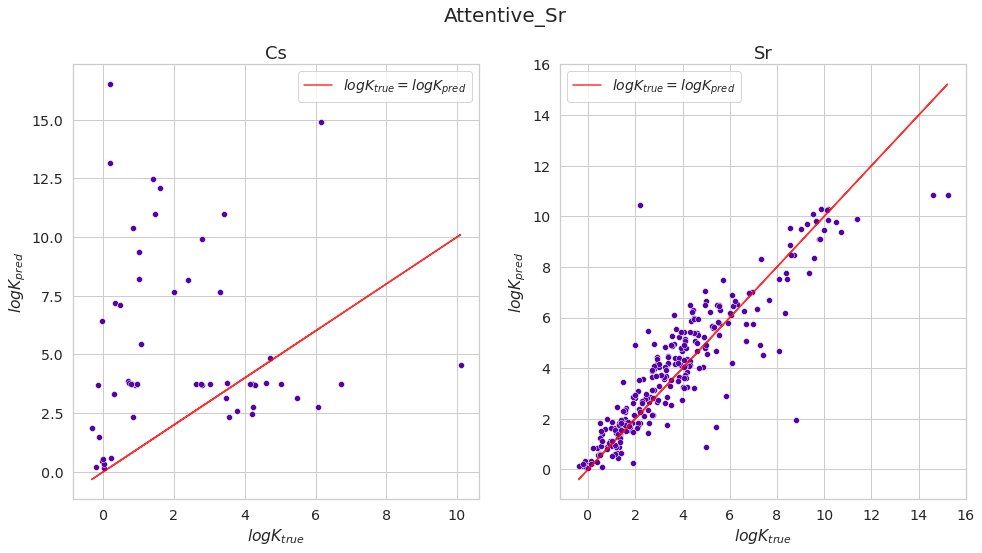

In [47]:
snake_df = get_df(model, version, draw=True);